# Import Statements

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl

# Parameters

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '3H'
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
spikes_file = filepath_root+'ankit/spikes.csv'
time_high_file = filepath_root+'ankit/time_high_3H.pkl'
time_low_file = filepath_root+'ankit/time_low_3H.pkl'
space_high_file = filepath_root+'ankit/space_high_3H.pkl'
space_low_file = filepath_root+'ankit/space_low_3H.pkl'

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

# Load Hotspots

In [4]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [5]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

In [6]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Hotspot_Counts

In [7]:
# shsp_high is list of list. Every element list has timestamp, hotspot centre and other locations inside hotspot.
print(len(shsp_high))

shsp_high = np.array(shsp_high)

# Find the number of locations with highest number of spatial high hotspots.

shsp_high_counts = {}
for col in df.columns:
    shsp_high_counts[col] = 0

for i in range(len(shsp_high)):
    hsp = shsp_high[i]
    shsp_high_counts[hsp[1]] += 1
    for loc in hsp[2]:
#         if(df.loc[hsp[0]][hsp[1]]-df.loc[hsp[0]][loc]<50):
        shsp_high_counts[loc] += 1

df_counts_sph = pd.DataFrame.from_dict(shsp_high_counts,orient='Index',columns=['spatial_high'])

1969


/state/partition1/job-19505561/ipykernel_235983/1545836603.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_high = np.array(shsp_high)


In [8]:
# shsp_low is list of list. Every element list has timestamp, hotspot centre and other locations inside hotspot.
print(len(shsp_low))

shsp_low = np.array(shsp_low)

# Find the number of locations with highest number of spatial low hotspots.

shsp_low_counts = {}
for col in df.columns:
    shsp_low_counts[col] = 0

for i in range(len(shsp_low)):
    hsp = shsp_low[i]
    shsp_low_counts[hsp[1]] += 1
    for loc in hsp[2]:
#         if(df.loc[hsp[0]][loc]-df.loc[hsp[0]][hsp[1]]<50):
        shsp_low_counts[loc] += 1

df_counts_spl = pd.DataFrame.from_dict(shsp_low_counts,orient='Index',columns=['spatial_low'])

853


/state/partition1/job-19505561/ipykernel_235983/81904359.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_low = np.array(shsp_low)


In [9]:
num_hsps = 0
for col in df.columns:
    num_hsps += len(thsp_high[col])
print(num_hsps)

thsp_high_counts = {key:len(value) for key,value in thsp_high.items()}

df_counts_tmh = pd.DataFrame.from_dict(thsp_high_counts,orient='Index',columns=['temporal_high'])

3528


In [10]:
num_hsps = 0
for col in df.columns:
    num_hsps += len(thsp_low[col])
print(num_hsps)

thsp_low_counts = {key:len(value) for key,value in thsp_low.items()}

df_counts_tml = pd.DataFrame.from_dict(thsp_low_counts,orient='Index',columns=['temporal_low'])

df_counts = df_counts_sph.join(other=[df_counts_spl, df_counts_tmh, df_counts_tml])

1653


In [11]:
# df_counts.to_csv('hotspot_counts_3H.csv')

## Results

In [12]:
df_counts.sort_values(by=['temporal_low'], ascending=False)[:10]

,spatial_high,spatial_low,temporal_high,temporal_low
Rohini_DPCC,201,6,149,101
Jahangirpuri_DPCC,212,5,124,84
Wazirpur_DPCC,246,6,130,82
NehruNagar_DPCC,247,1,136,80
AshokVihar_DPCC,127,41,99,72
AnandVihar_DPCC,183,3,130,70
Mundaka_DPCC,208,11,135,70
BurariCrossing_IMD,99,8,77,57
PunjabiBagh_DPCC,146,14,136,55
VivekVihar_DPCC,124,65,117,54


In [13]:
df_counts.sort_values(by=['spatial_low'], ascending=False)[:15]

,spatial_high,spatial_low,temporal_high,temporal_low
Pusa_IMD,17,101,49,12
LodhiRoad_IMD,13,96,36,11
NSIT_CPCB,36,94,50,11
IGIAirport_IMD,13,89,51,20
AyaNagar_IMD,38,80,47,9
MDCNS_DPCC,20,73,45,17
SriAurobindoMarg_DPCC,10,70,36,18
VivekVihar_DPCC,124,65,117,54
DwarkaSector8_DPCC,28,62,81,42
IHBAS_CPCB,87,57,80,25


In [14]:
locs.loc['8E2A']

UDID         ab7cf790c51e426a9c3a7551dddd8e2a
Latitude                            28.474103
Longitude                           77.122213
Address                           Roy Imaging
Location                  Aya Nagar Extension
Type                                 Kaiterra
Name: 8E2A, dtype: object

In [15]:
df_counts.sort_values(by=['temporal_high'], ascending=False)[:10]

,spatial_high,spatial_low,temporal_high,temporal_low
Rohini_DPCC,201,6,149,101
PunjabiBagh_DPCC,146,14,136,55
NehruNagar_DPCC,247,1,136,80
Mundaka_DPCC,208,11,135,70
Wazirpur_DPCC,246,6,130,82
AnandVihar_DPCC,183,3,130,70
Jahangirpuri_DPCC,212,5,124,84
DTU_CPCB,75,18,119,53
VivekVihar_DPCC,124,65,117,54
ITO_CPCB,70,35,100,41


In [16]:
df_counts.sort_values(by=['spatial_high'], ascending=False)[:20]

,spatial_high,spatial_low,temporal_high,temporal_low
NehruNagar_DPCC,247,1,136,80
Wazirpur_DPCC,246,6,130,82
Jahangirpuri_DPCC,212,5,124,84
Mundaka_DPCC,208,11,135,70
Rohini_DPCC,201,6,149,101
AnandVihar_DPCC,183,3,130,70
PunjabiBagh_DPCC,146,14,136,55
AshokVihar_DPCC,127,41,99,72
VivekVihar_DPCC,124,65,117,54
Shadipur_CPCB,107,55,87,16


# Common Occurance

In [17]:
co_thsh = 0
for col in df.columns:
    for i in range(len(thsp_high[col])):
        thsp = thsp_high[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[time][location]-df.loc[t][location]<50):
                shsp = shsp_high[shsp_high[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_thsh += 1
co_thsh

1204

In [18]:
co_tlsh = 0
for col in df.columns:
    for i in range(len(thsp_low[col])):
        thsp = thsp_low[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[t][location]-df.loc[time][location]<50):
                shsp = shsp_high[shsp_high[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_tlsh += 1
co_tlsh

54

In [19]:
co_thsl = 0
for col in df.columns:
    for i in range(len(thsp_high[col])):
        thsp = thsp_high[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[time][location]-df.loc[t][location]<50):
                shsp = shsp_low[shsp_low[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_thsl += 1
co_thsl

49

In [20]:
co_tlsl = 0
for col in df.columns:
    for i in range(len(thsp_low[col])):
        thsp = thsp_low[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[t][location]-df.loc[time][location]<50):
                shsp = shsp_low[shsp_low[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_tlsl += 1
co_tlsl

30

# Inferences: Temporal Hotspots

In [21]:
time_interest_locs = set(df_counts.sort_values(by=['temporal_high'], ascending=False)[:10].index).intersection(\
                            set(df_counts.sort_values(by=['temporal_low'], ascending=False)[:10].index))

/state/partition1/job-19505561/ipykernel_235983/3921831146.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_vals = np.array(high_hsps)[:,1]
/state/partition1/job-19505561/ipykernel_235983/3921831146.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_vals = np.array(low_hsps)[:,1]


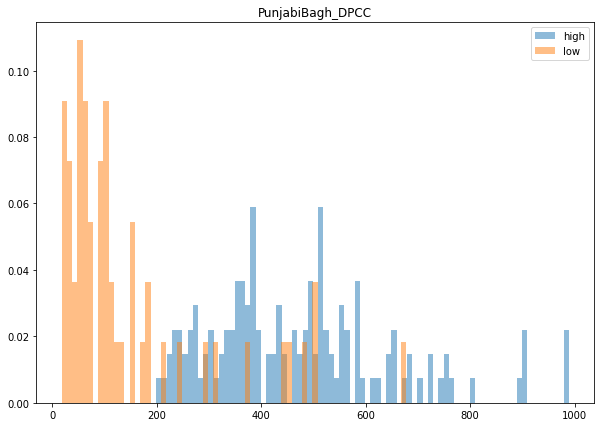

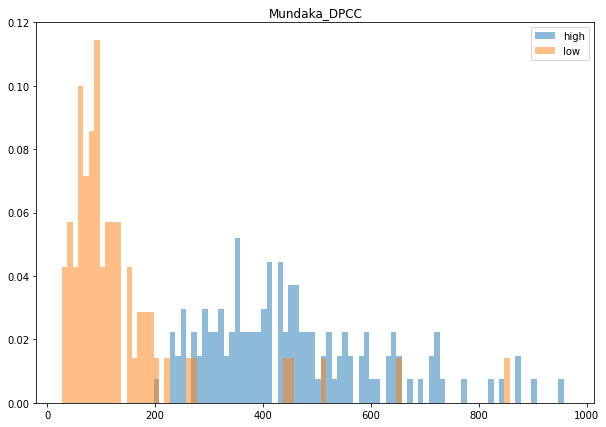

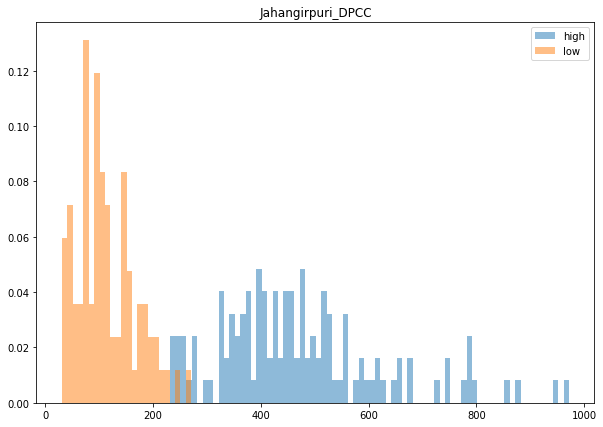

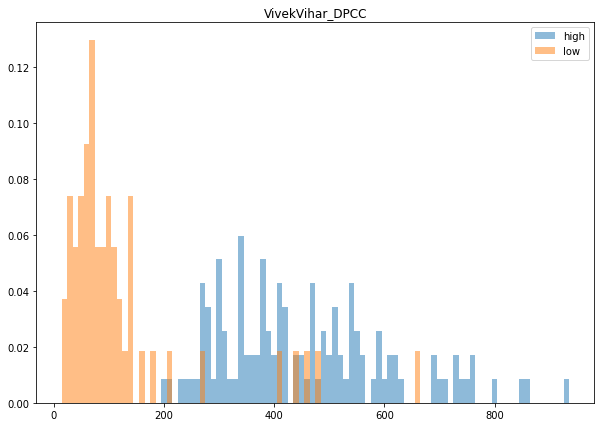

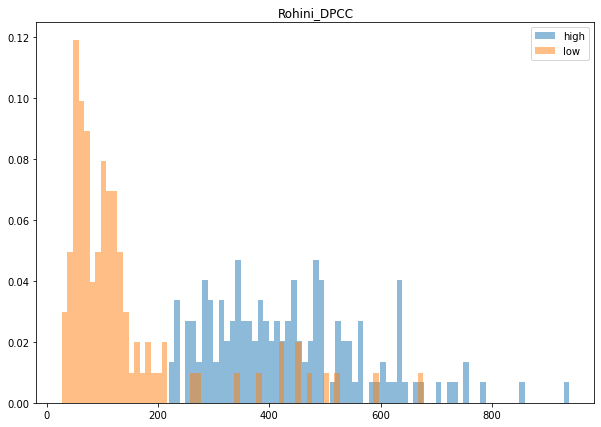

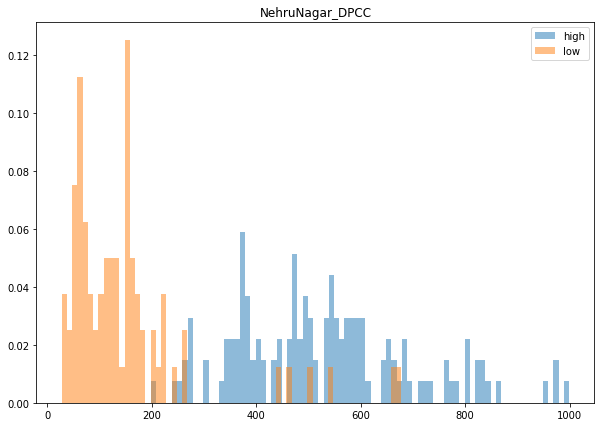

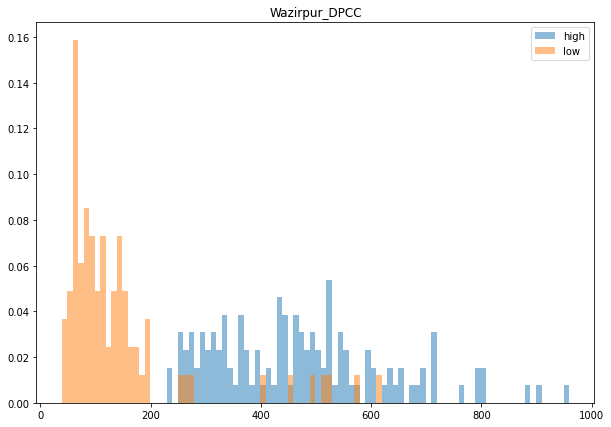

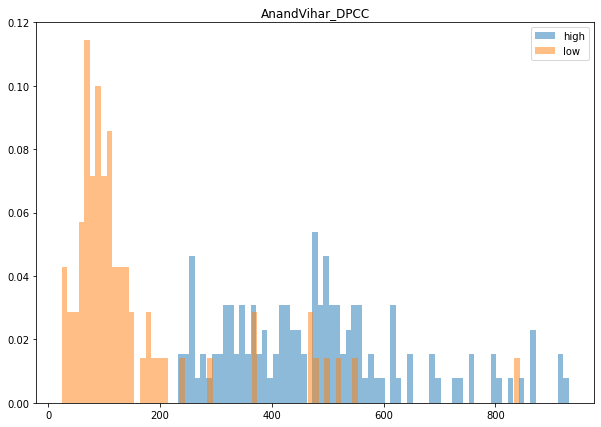

In [22]:
for location in list(time_interest_locs):
    high_hsps = thsp_high[location]
    low_hsps = thsp_low[location]
    high_vals = np.array(high_hsps)[:,1]
    low_vals = np.array(low_hsps)[:,1]
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
                bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
    stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
                bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
    plt.title(location)
    plt.legend()

In [23]:
high_pol_locs = set(df_counts.sort_values(by=['spatial_high'], ascending=False)[:10].index).intersection\
(time_interest_locs)

In [24]:
for location in high_pol_locs:
    print(location, df[location].mean(), df[location].std())

PunjabiBagh_DPCC 102.61837409868514 106.5567128095764
Mundaka_DPCC 116.51601454765873 118.42891255711518
Jahangirpuri_DPCC 119.56125104369606 112.76653861575384
VivekVihar_DPCC 101.47838988968022 103.59810767448408
Rohini_DPCC 116.55189862783533 112.60002521392244
NehruNagar_DPCC 110.83204182718768 121.35814053212074
Wazirpur_DPCC 118.78676101505856 116.42626335045303
AnandVihar_DPCC 121.78385108712655 117.85420238154572


In [25]:
print(df['Jahangirpuri_DPCC'].mean(), df['Jahangirpuri_DPCC'].std())

119.56125104369606 112.76653861575384


/state/partition1/job-19505561/ipykernel_235983/433554290.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_vals = np.array(high_hsps)[:,1]
/state/partition1/job-19505561/ipykernel_235983/433554290.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_vals = np.array(low_hsps)[:,1]


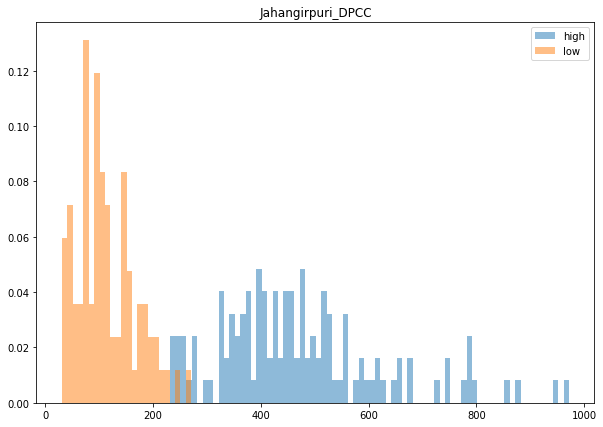

In [26]:
location = 'Jahangirpuri_DPCC'
high_hsps = thsp_high[location]
low_hsps = thsp_low[location]
high_vals = np.array(high_hsps)[:,1]
low_vals = np.array(low_hsps)[:,1]
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
            bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
            bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
plt.title(location)
plt.legend()

In [27]:
roi_vals = (stats_low[1]+5)[stats_low[1]<200]
(stats_low[0][:len(roi_vals)]).sum()

0.9285714285714274

# Compare with only Government Data Hotspots

In [ ]:
df_gov = pd.read_csv('govhotspot_counts_3H.csv',index_col=0)
df_com = pd.read_csv('hotspot_counts_3H.csv',index_col=0)
df_gov.columns = df_gov.columns + '_gov'
df_com.columns = df_com.columns + '_com'

In [36]:
df_hotspots = df_com.join([df_gov])

In [ ]:
df_hotspots.sort_values(by=['spatial_low_gov'], ascending=False)[:10]

In [ ]:
df_hotspots.sort_values(by=['spatial_low_com'], ascending=False)[:10]

In [ ]:
# df_hotspots

In [38]:
shsp_high

array([[Timestamp('2018-05-01 12:00:00+0530', tz='pytz.FixedOffset(330)'),
        'MandirMarg_DPCC', list([])],
       [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
        'AyaNagar_IMD', list([])],
       [Timestamp('2018-05-02 15:00:00+0530', tz='pytz.FixedOffset(330)'),
        'BurariCrossing_IMD', list([])],
       ...,
       [Timestamp('2020-10-30 06:00:00+0530', tz='pytz.FixedOffset(330)'),
        'DTU_CPCB', list(['Rohini_DPCC', 'Jahangirpuri_DPCC'])],
       [Timestamp('2020-10-31 00:00:00+0530', tz='pytz.FixedOffset(330)'),
        'Jahangirpuri_DPCC',
        list(['PunjabiBagh_DPCC', 'SoniaVihar_DPCC'])],
       [Timestamp('2020-10-31 00:00:00+0530', tz='pytz.FixedOffset(330)'),
        'VivekVihar_DPCC',
        list(['AnandVihar_DPCC', 'Patparganj_DPCC', 'ITO_CPCB'])]],
      dtype=object)

In [ ]:
shsp_high[:,2]

# Inferences: Spatial Hotspots

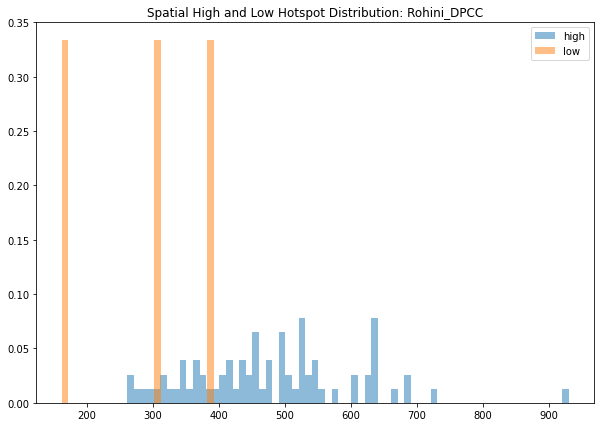

In [29]:
val_high = []
val_low = []
station = 'Rohini_DPCC'
for i in range(len(shsp_high[shsp_high[:,1]==station])):
    hsp_loc = shsp_high[shsp_high[:,1]==station][i][1]
    hsp_time = shsp_high[shsp_high[:,1]==station][i][0]
    val = df.loc[hsp_time][hsp_loc]
    val_high.append(val)
for i in range(len(shsp_low[shsp_low[:,1]==station])):
    hsp_loc = shsp_low[shsp_low[:,1]==station][i][1]
    hsp_time = shsp_low[shsp_low[:,1]==station][i][0]
    val = df.loc[hsp_time][hsp_loc]
    val_low.append(val)
    
high_vals = np.array(val_high)
low_vals = np.array(val_low)
    
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
            bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
            bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
plt.title('Spatial High and Low Hotspot Distribution: '+station)
plt.legend()

In [30]:
roi_vals = (stats_low[1]+5)[stats_low[1]<200]
(stats_low[0][:len(roi_vals)]).sum()

0.3333333333333333

In [39]:
low_pol_locs = list(df_counts.sort_values(by=['spatial_low'], ascending=False)[:10].index)

In [40]:
for location in low_pol_locs:
    print(location, df[location].mean(), df[location].std())

Pusa_IMD 76.73656137724551 76.880506230685
LodhiRoad_IMD 77.04841897810218 71.64463571079081
NSIT_CPCB 97.19454933847851 75.45529246374501
IGIAirport_IMD 79.72844107013738 77.93943823599132
AyaNagar_IMD 76.38852652825837 71.65565244237025
MDCNS_DPCC 86.4155242825607 80.24701518578178
SriAurobindoMarg_DPCC 80.50552768294493 80.07912569652738
VivekVihar_DPCC 101.47838988968022 103.59810767448408
DwarkaSector8_DPCC 95.6859166781625 92.96655519108369
IHBAS_CPCB 94.68428391432171 85.81410999461924


In [41]:
for location in low_pol_locs:
    roi_hsp = shsp_low[shsp_low[:,1]==location]
    vals = df.loc[roi_hsp[:,0]][location]
    print(location, vals.mean(), vals.std())

Pusa_IMD 169.88608695652172 113.63810899279757
LodhiRoad_IMD 207.79593220338978 96.64347626124277
NSIT_CPCB 193.82437499999997 119.69353980265814
IGIAirport_IMD 209.9637037037037 104.078934953907
AyaNagar_IMD 206.86830985915492 75.76917066206349
MDCNS_DPCC 155.44117647058823 123.49187098157276
SriAurobindoMarg_DPCC 273.59083333333336 82.76810842329125
VivekVihar_DPCC 78.66196721311475 68.23129247443758
DwarkaSector8_DPCC 140.8409756097561 94.57742721719804
IHBAS_CPCB 149.58575000000002 94.3014192700521


In [42]:
for location in high_pol_locs:
    roi_hsp = shsp_high[shsp_high[:,1]==location]
    vals = df.loc[roi_hsp[:,0]][location]
    print(location, vals.mean(), vals.std())

PunjabiBagh_DPCC 481.609898989899 200.26497741892348
Mundaka_DPCC 508.6102285714286 152.59852211119926
Jahangirpuri_DPCC 491.63859259259266 154.09094210578763
VivekVihar_DPCC 476.0932857142857 155.70773017700085
Rohini_DPCC 478.7594805194806 124.33685463602181
NehruNagar_DPCC 503.211 162.27608461136305
Wazirpur_DPCC 492.7438655462185 147.62913696672854
AnandVihar_DPCC 530.8358156028369 160.50856277183485


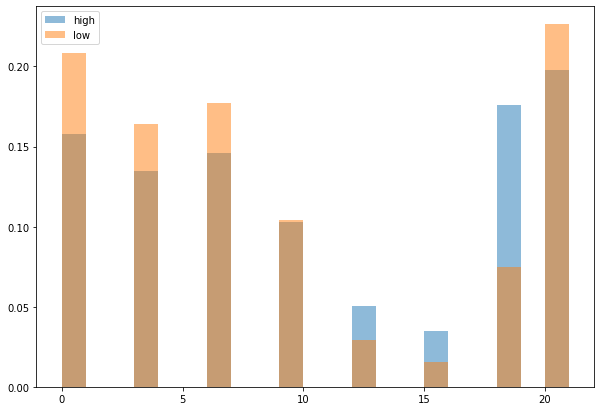

In [43]:
time_high = []
for i in range(len(shsp_high)):
    time_high.append(shsp_high[i][0].time().hour)
time_low = []
for i in range(len(shsp_low)):
    time_low.append(shsp_low[i][0].time().hour)
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(time_high, weights=np.ones(len(time_high))/len(time_high), \
                 bins=range(int(min(time_high)),int(max(time_high)) + 1, 1), cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(time_low, weights=np.ones(len(time_low))/len(time_low), \
                 bins=range(int(min(time_low)),int(max(time_low)) + 1, 1), cumulative=False,alpha=0.5,label='low')
plt.legend()

# Duration for Temporal Hotspots

/state/partition1/job-19505561/ipykernel_235983/1640478924.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_time_wins = np.array(high_hsps)[:,2]
/state/partition1/job-19505561/ipykernel_235983/1640478924.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_time_wins = np.array(low_hsps)[:,2]


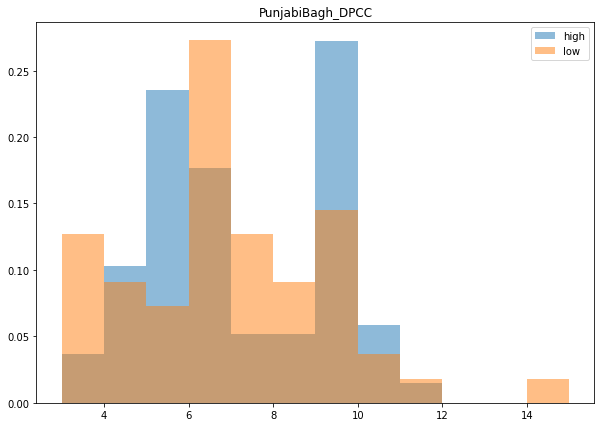

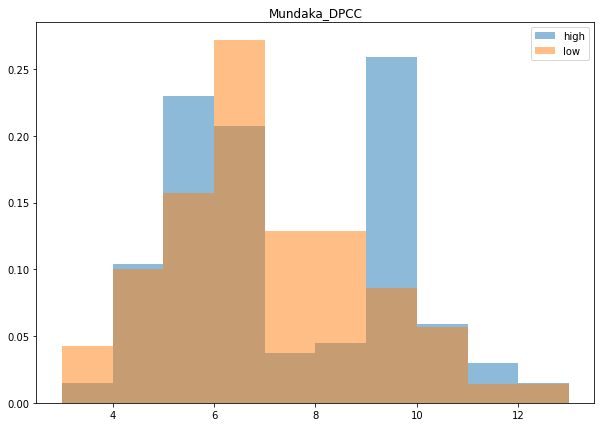

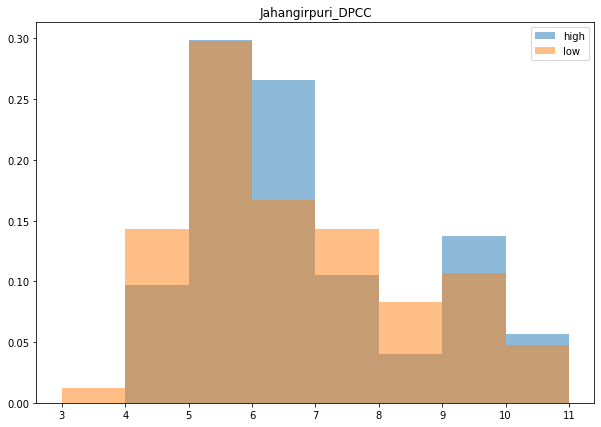

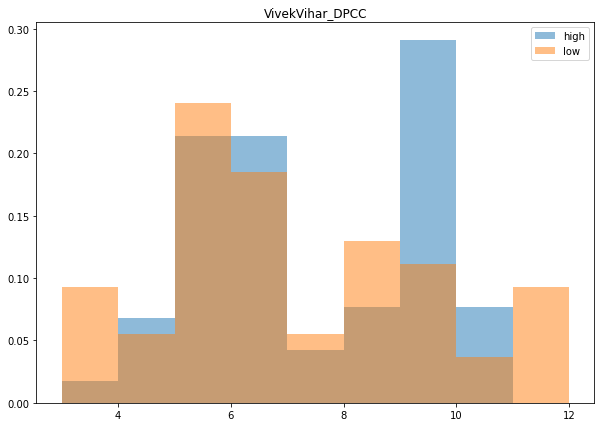

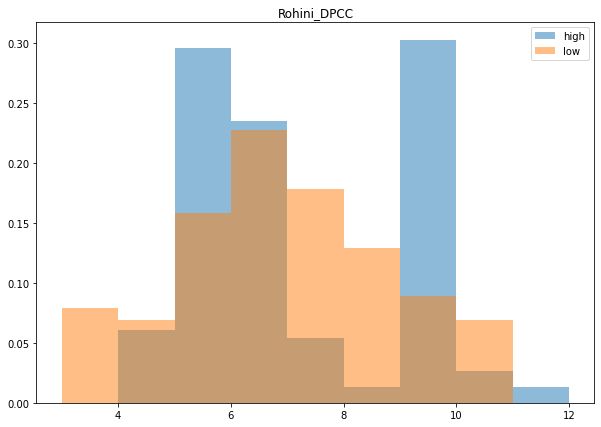

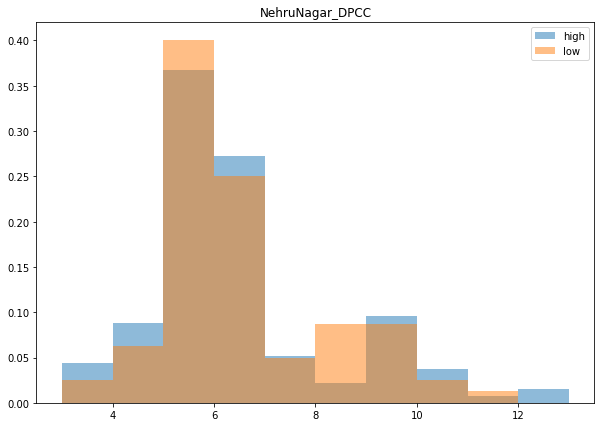

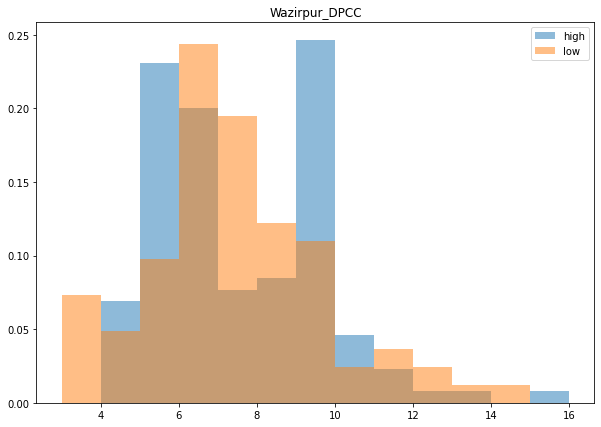

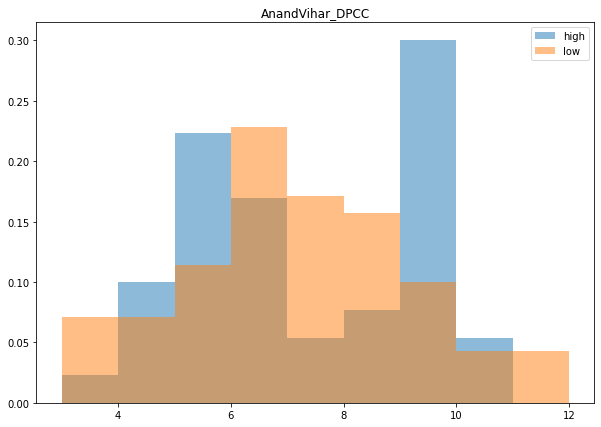

In [44]:
for location in list(time_interest_locs):
    high_hsps = thsp_high[location]
    low_hsps = thsp_low[location]
    high_time_wins = np.array(high_hsps)[:,2]
    f = lambda x: len(x)
    high_ints = np.array([f(xi) for xi in high_time_wins])
    low_time_wins = np.array(low_hsps)[:,2]
    low_ints = np.array([f(xi) for xi in low_time_wins])
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(high_ints, weights=np.ones(len(high_ints))/len(high_ints),\
                bins=range(int(min(high_ints)),int(max(high_ints)) + 1, 1),cumulative=False,alpha=0.5,label='high')
    stats_low = plt.hist(low_ints, weights=np.ones(len(low_ints))/len(low_ints),\
                bins=range(int(min(low_ints)),int(max(low_ints)) + 1, 1),cumulative=False,alpha=0.5,label='low')
    plt.title(location)
    plt.legend()

# Radius of Spatial Hotspots

In [45]:
# nn_dict = {}
# for col in df.columns:
#     dist_df = distances.loc[col].sort_values().dropna()
#     nn_dict[col] = dist_df

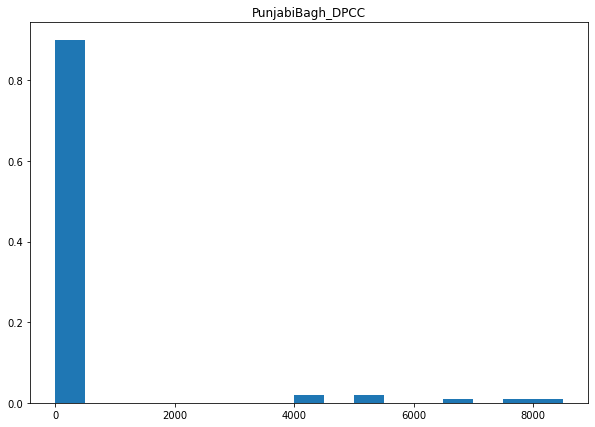

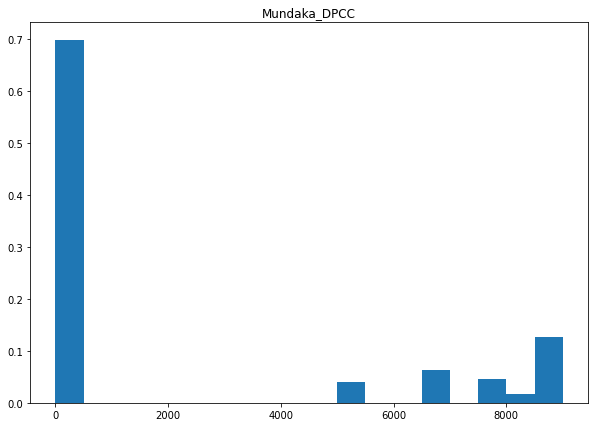

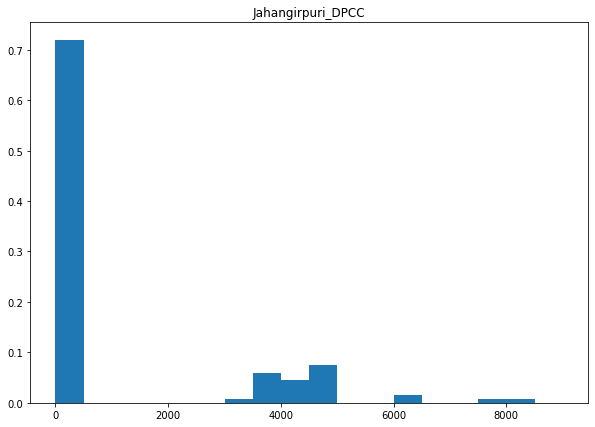

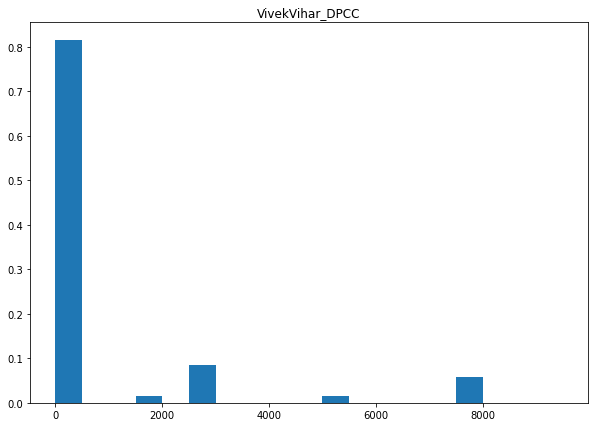

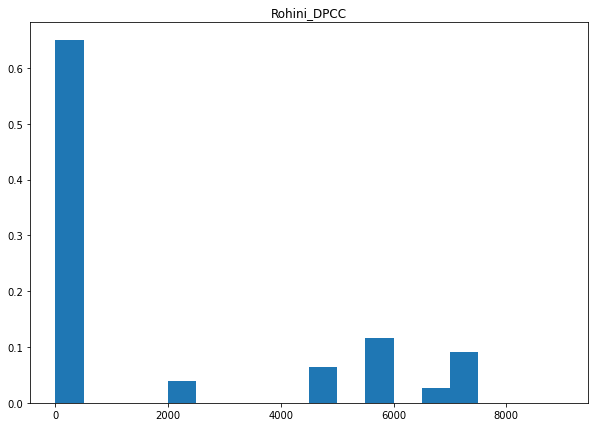

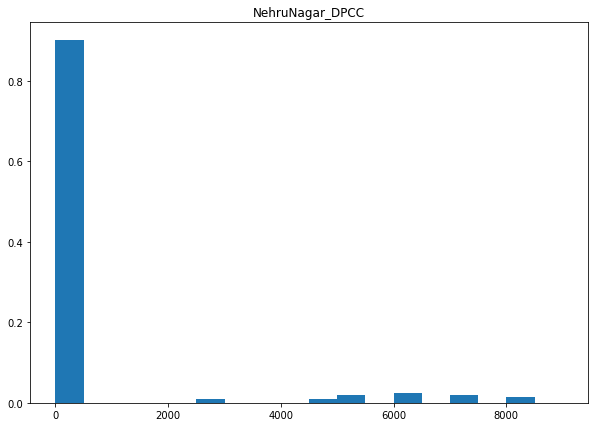

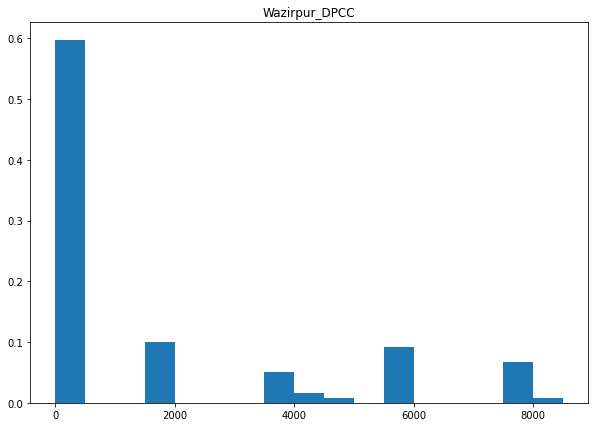

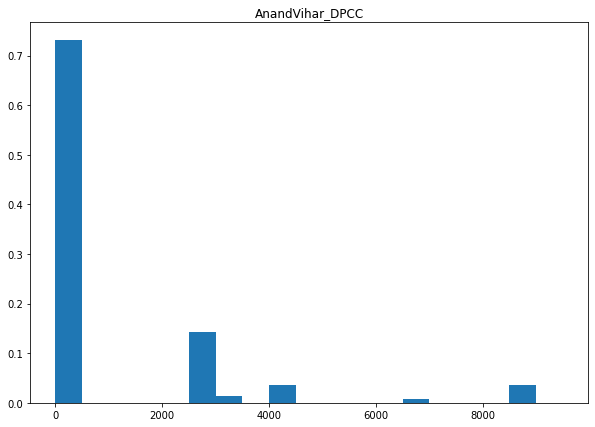

In [46]:
for location in high_pol_locs:
    roi_hsp = shsp_high[shsp_high[:,1]==location]
    dist = []
    for hsp in roi_hsp:
        time = hsp[0]
        cen = hsp[1]
        d = 0
        for stn in hsp[2]:
            if(df.loc[time][cen]-df.loc[time][stn]<50):
                d = max(d,distances.loc[cen][stn])
        dist.append(d)
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(dist, weights=np.ones(len(dist))/len(dist),\
                bins=range(int(min(dist)),int(max(dist)) + 1, 500),cumulative=False,alpha=1,label='high')
    plt.title(location)

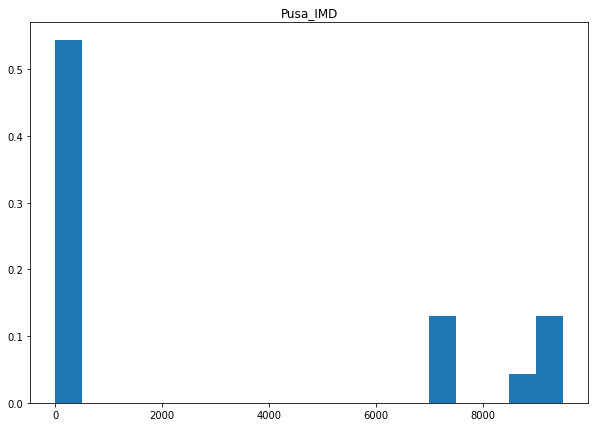

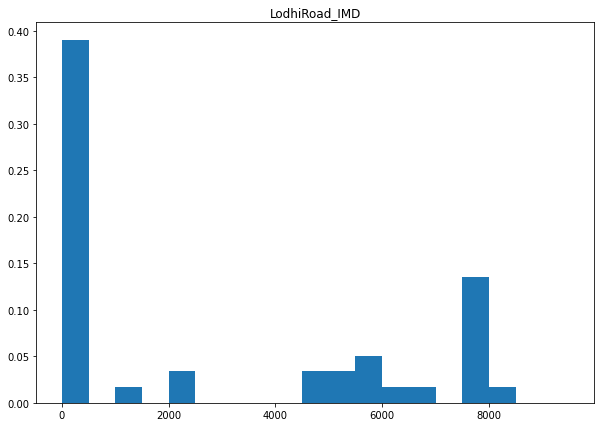

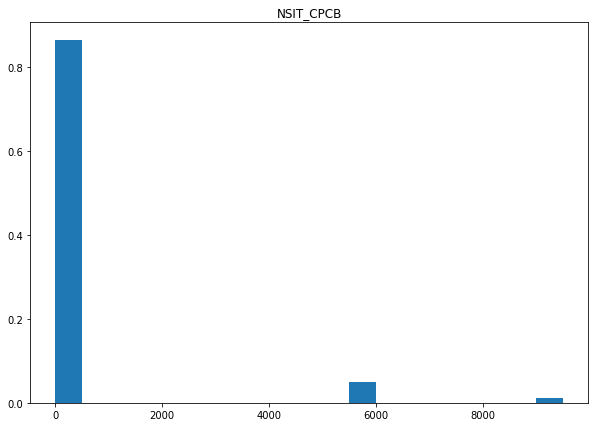

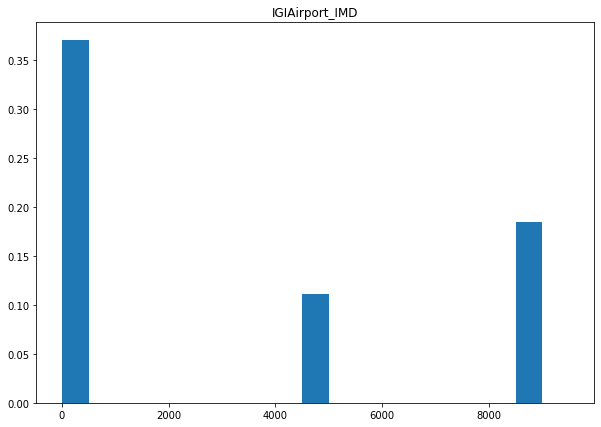

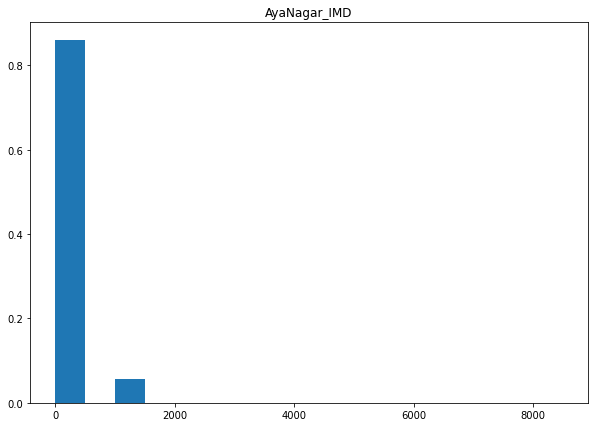

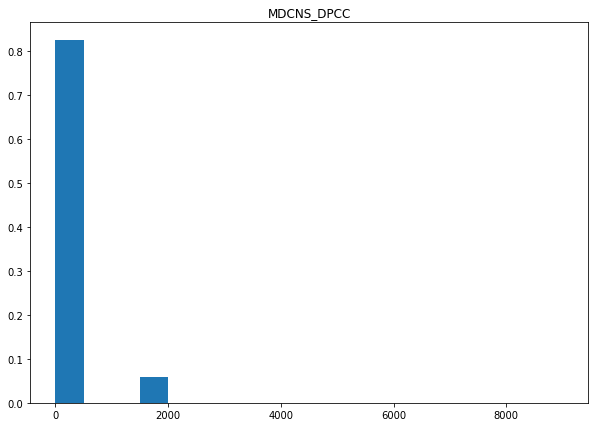

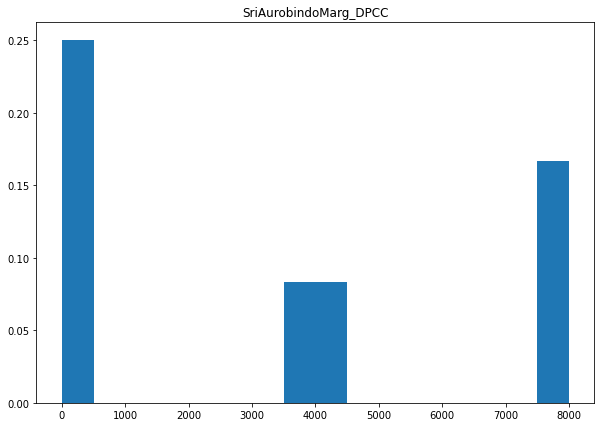

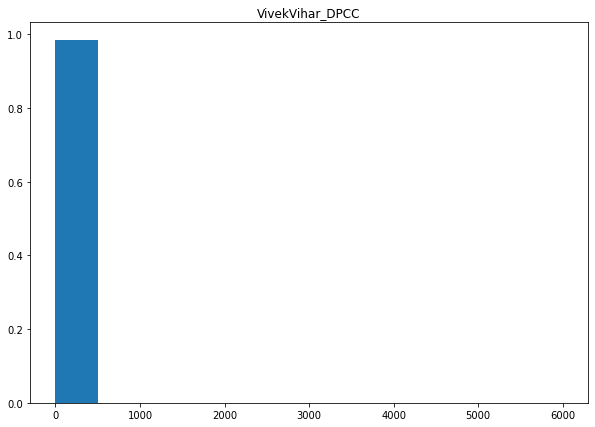

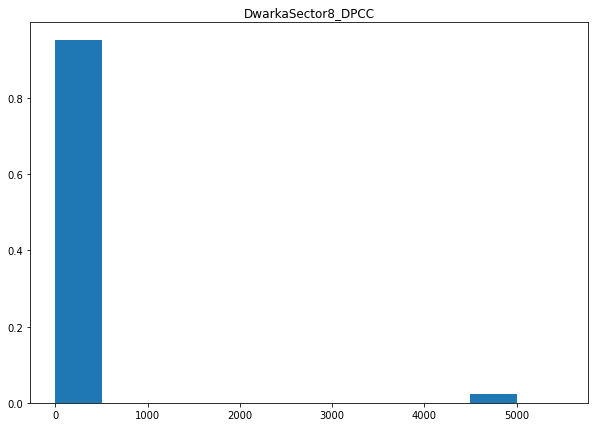

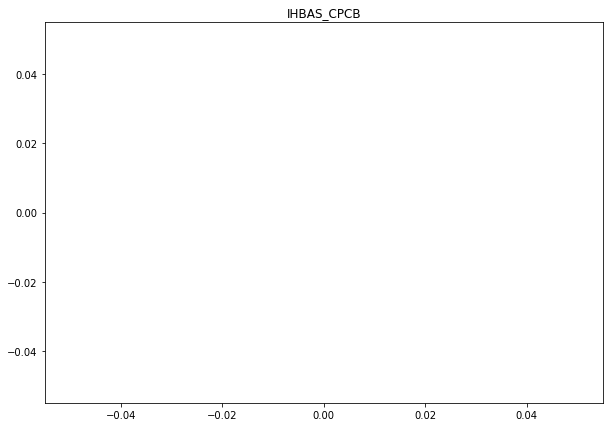

In [47]:
for location in low_pol_locs:
    roi_hsp = shsp_low[shsp_low[:,1]==location]
    dist = []
    for hsp in roi_hsp:
        time = hsp[0]
        cen = hsp[1]
        d = 0
        for stn in hsp[2]:
            if(df.loc[time][stn]-df.loc[time][cen]<50):
                d = max(d,distances.loc[cen][stn])
        dist.append(d)
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(dist, weights=np.ones(len(dist))/len(dist),\
                bins=range(int(min(dist)),int(max(dist)) + 1, 500),cumulative=False,alpha=1,label='high')
    plt.title(location)

# Magnitude of Temporal Hotspots (Longitudnal)

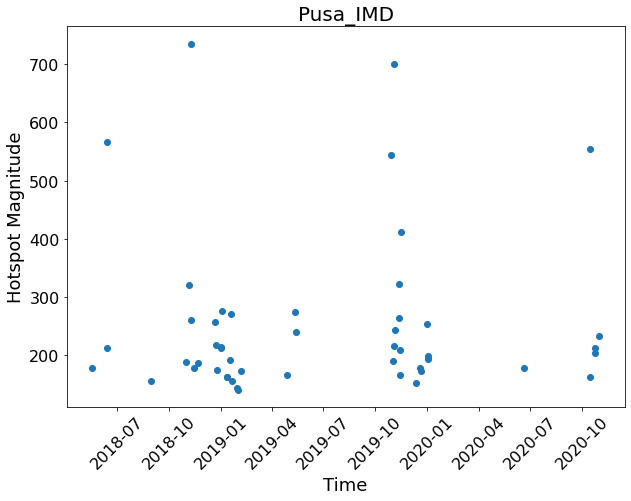

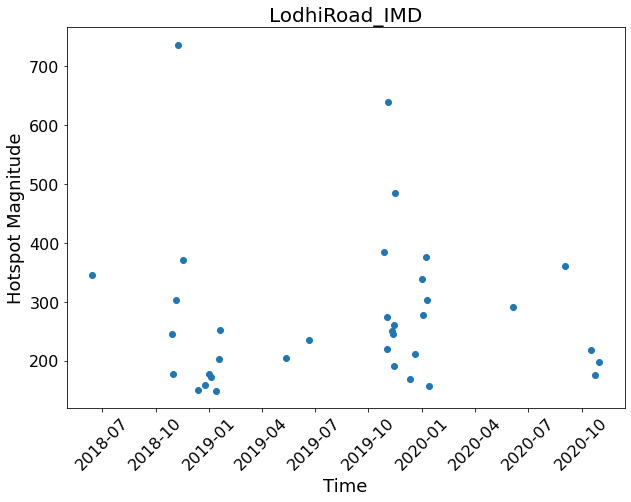

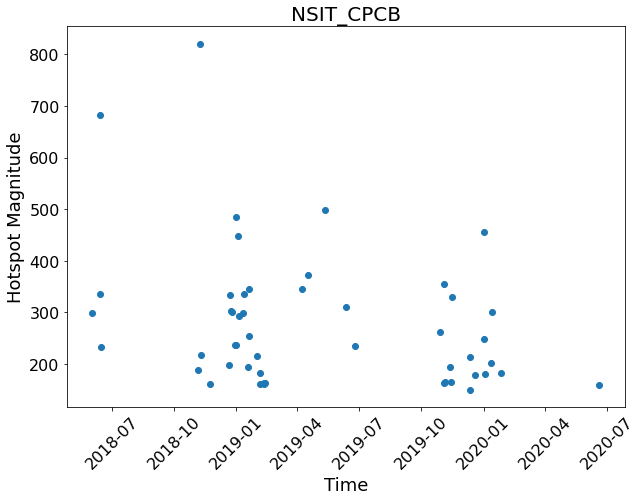

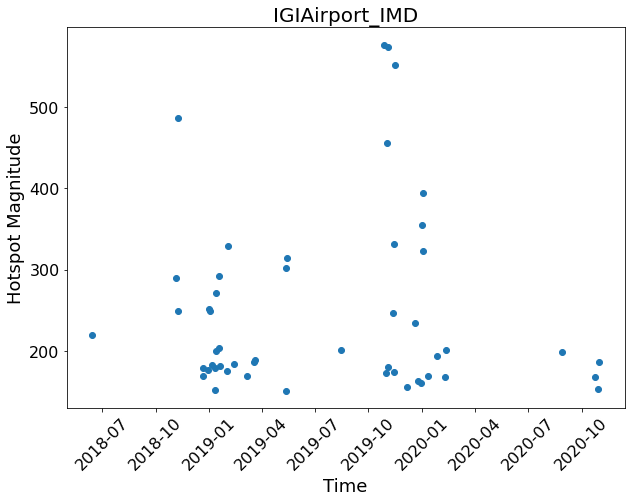

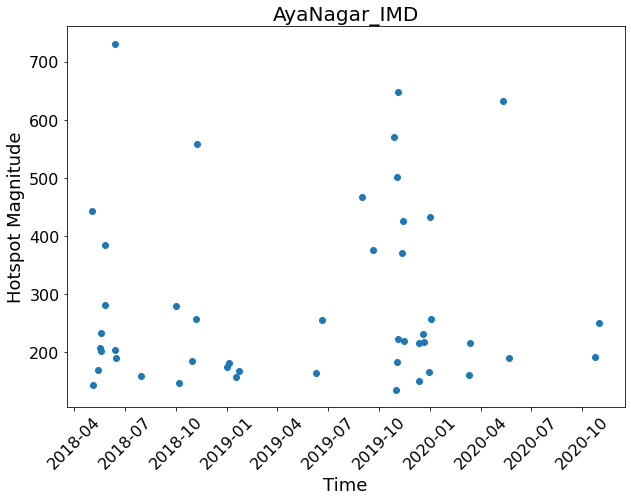

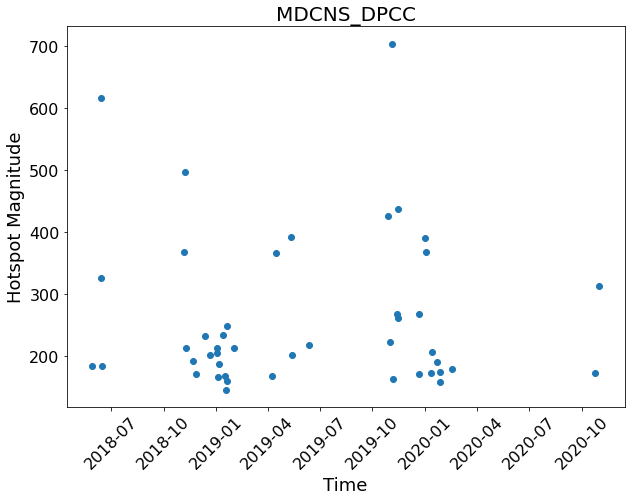

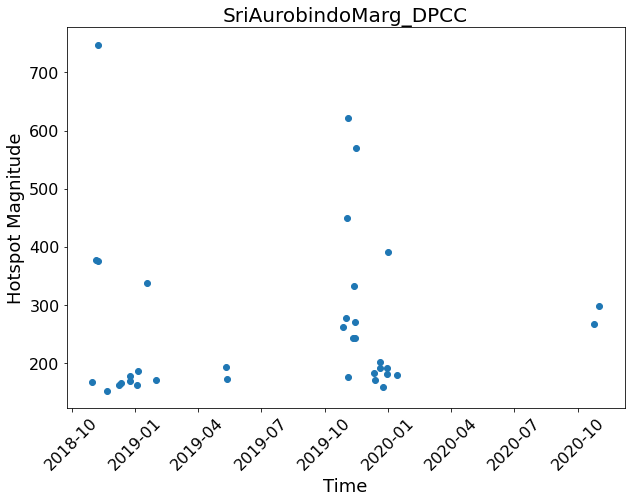

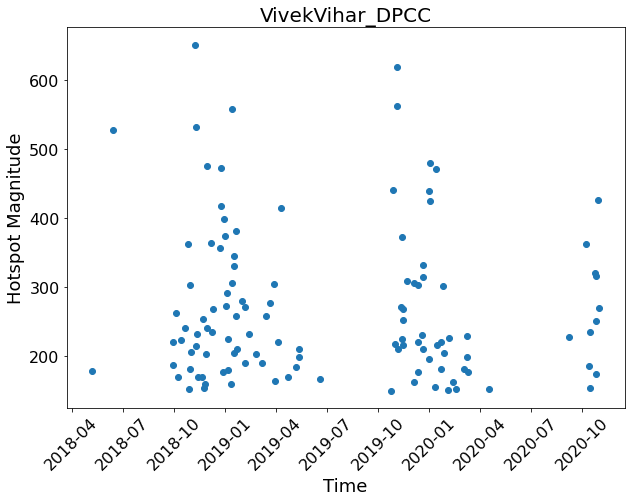

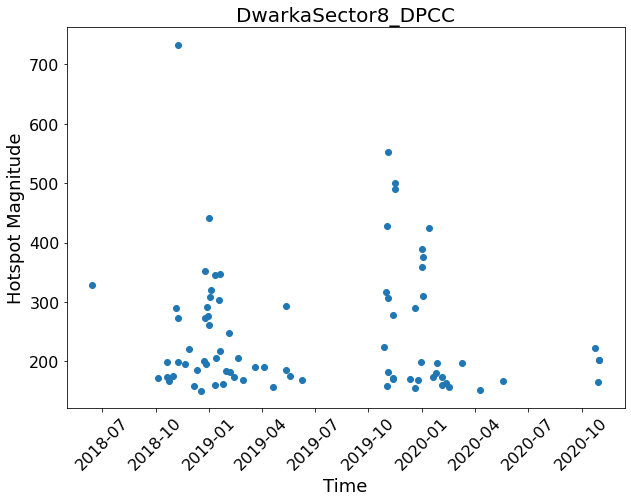

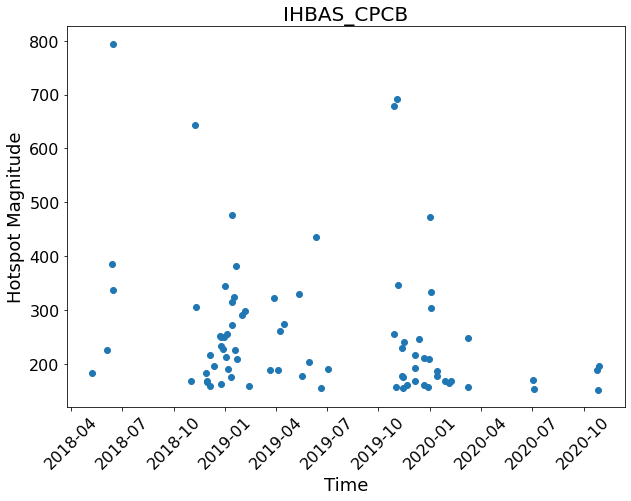

In [57]:
plt.rcParams.update({'font.size': 16})
for station in df_counts.sort_values(by=['spatial_low'], ascending=False)[:10].index:
    hsp_mag = []
    x = []
    for i in range(len(thsp_high[station])):
        hsp = thsp_high[station][i]
        ts_le = hsp[2][0]
        ts_rb = hsp[2][-1]
        wind = len(hsp[2])
        ts = hsp[0]
        idx = list(df[station].index)
        idx_le = idx.index(ts_le)
        idx_rb = idx.index(ts_rb)
        idx_re = idx_rb+5*wind
        idx_lb = idx_le-5*wind
        idx_lb = max(0,idx_lb)
        idx_re = min(idx_re,len(df))
        idxs = np.concatenate((np.array(idx)[idx_lb:idx_le+1],np.array(idx)[idx_rb:idx_re+1]))
        y = df[station].loc[idxs].values
        avg_y = np.nanmean(y)
#         x = range(len(y))
#         fig, ax = plt.subplots(figsize=(5,3.5))
#         plt.plot(x,y)
#         plt.axhline(y=np.nanmean(y), linestyle='--', alpha=0.5)
        
#         hsp_idx = np.where(idxs==ts)[0][0]
#         diwali_idx = np.where(idxs==diwali_ts)[0][0]
#         plt.scatter(x[hsp_idx],y[hsp_idx],s=100)
#             plt.scatter(x[diwali_idx],y[diwali_idx],s=400,alpha=0.1,color='r')
#         plt.axvline(x=diwali_idx, linestyle='--', alpha=0.5,color='r')
        # ax = plt.gca()
        hsp_mag.append(hsp[1] - avg_y)
        x.append(ts)
#         ax.axes.xaxis.set_ticks([])
#         plt.xlabel('Time')
#         plt.ylabel('PM2.5')
#         plt.title(station)
#         plt.savefig("temporal_hotspot.png")
#     plt.figure()
#     plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(10,7))
    y = np.array(hsp_mag)
    plt.scatter(x,y)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Hotspot Magnitude',fontsize=18)
    plt.title(station,fontsize=20)
    plt.xticks(rotation = 45)
    plt.show()

# Magnitude of Spatial Hotspots (Longitudinal)

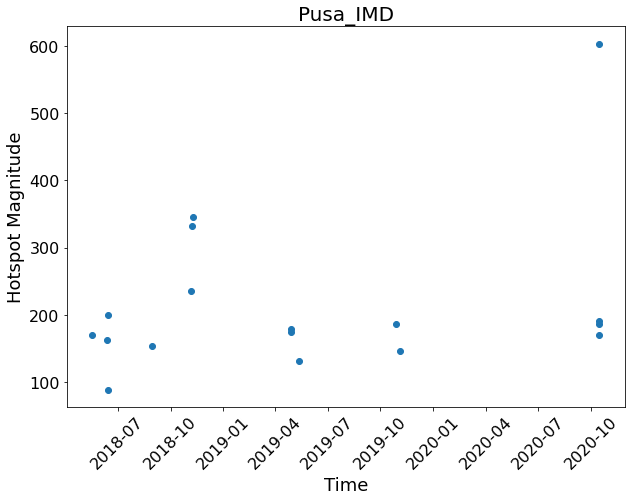

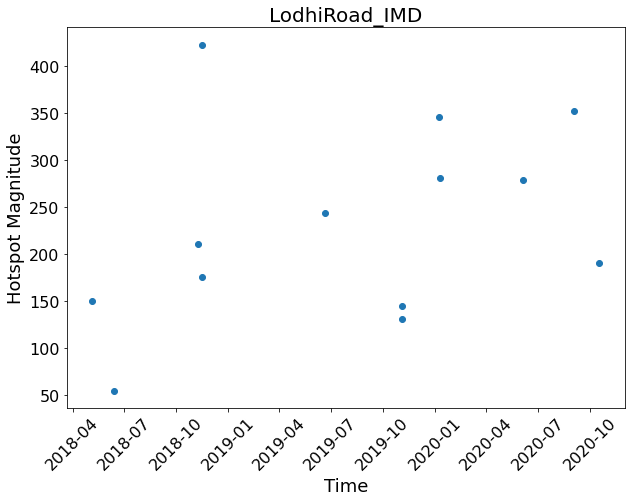

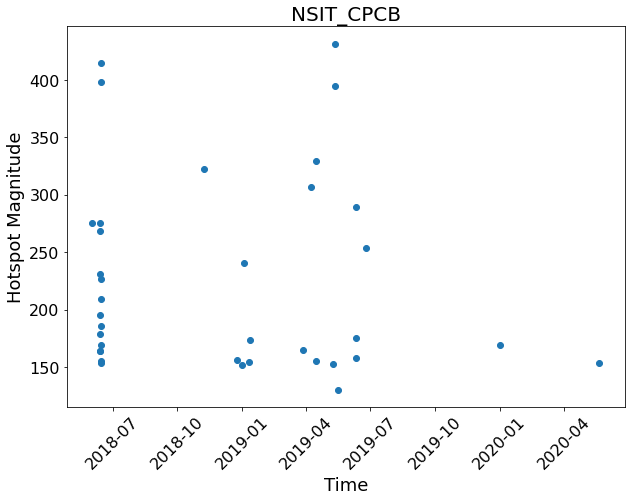

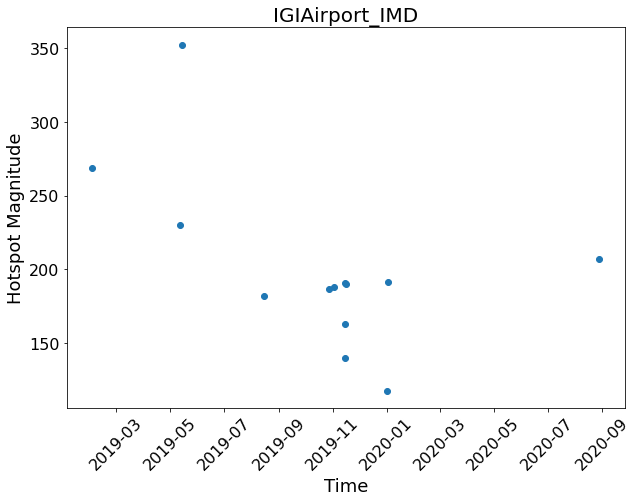

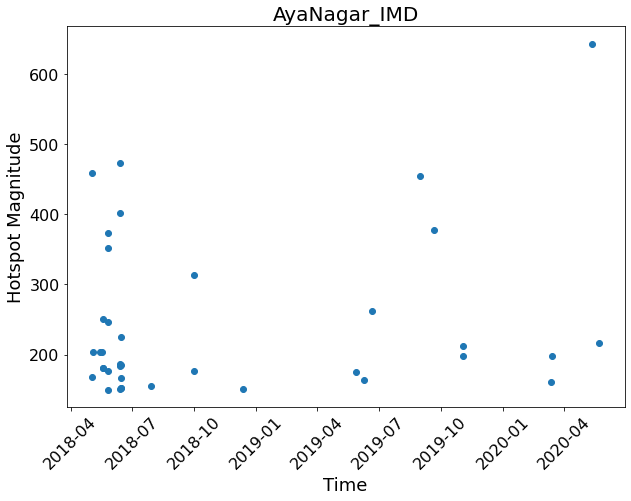

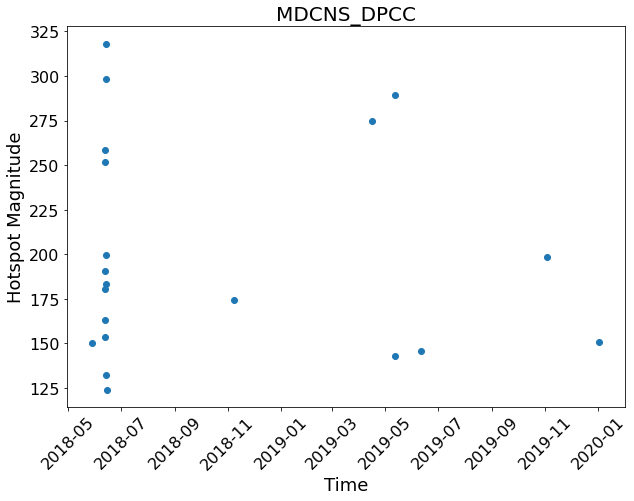

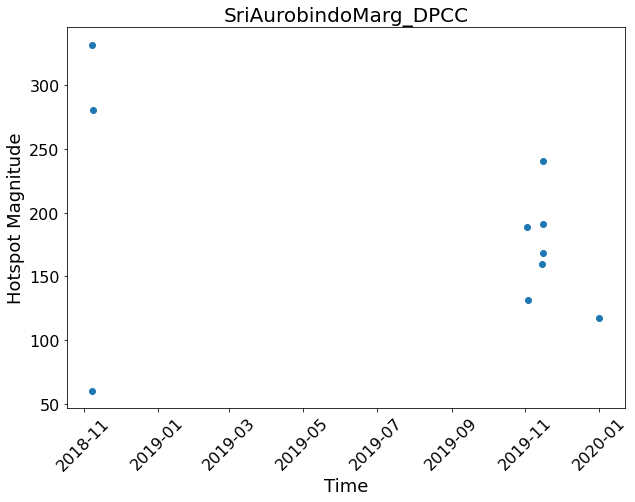

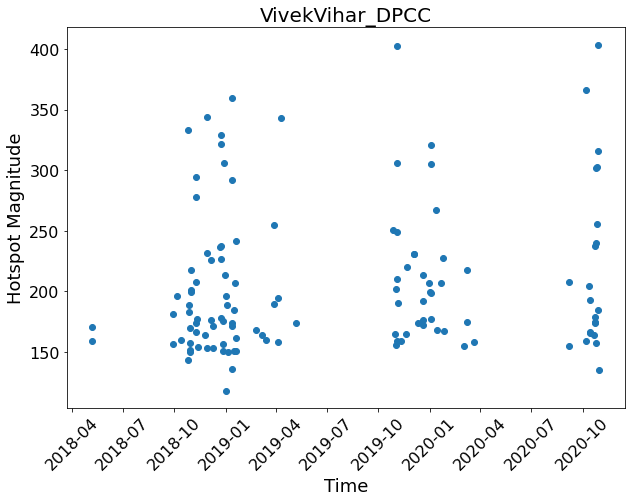

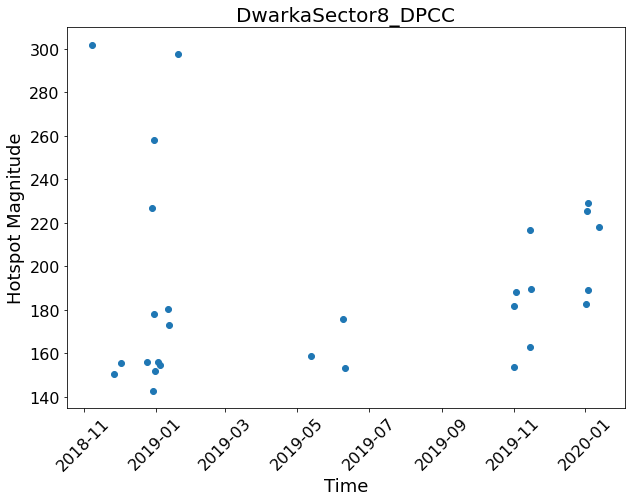

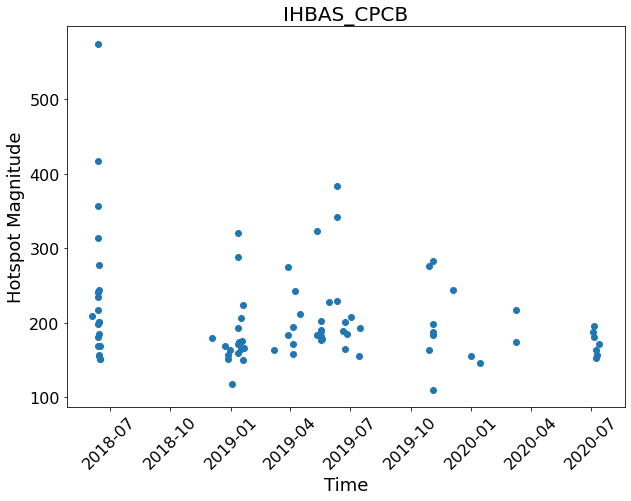

In [55]:
plt.rcParams.update({'font.size': 16})
nn_dict = {}
for col in df.columns:
    dist_df = distances.loc[col].sort_values().dropna()
    nn_dict[col] = dist_df
for station in df_counts.sort_values(by=['spatial_low'], ascending=False)[:10].index:
    hsp_mag = []
    x = []
    for i in range(len(shsp_high)):
        hsp = shsp_high[i]
        if(station==hsp[1] or station in hsp[2]):
            ts = hsp[0]
            df_snap = df.loc[ts].dropna()
            loc_list = list(df_snap.index)
            available_locs = [x for x in loc_list if x != hsp[0]]
            sp_nh = list(nn_dict[hsp[1]][nn_dict[hsp[1]]<20*1000].index)
#             print(sp_nh)
            avg_locs = [x for x in sp_nh if x in available_locs]
            avg_reading = df_snap[avg_locs].mean()
            hsp_mag.append(df.loc[ts][hsp[1]] - avg_reading)
            x.append(ts)

    fig, ax = plt.subplots(figsize=(10,7))
    y = np.array(hsp_mag)
    plt.scatter(x,y)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Hotspot Magnitude',fontsize=18)
    plt.title(station,fontsize=20)
    plt.xticks(rotation = 45)
    plt.show()

In [ ]:
df_counts